# Central Pattern Generator for control of quadruped robot

This is part 1 of the Legged robot course's project \#2. We will focus on implementing a montion controller based on a Central Pattern Generato (CPG).

## Importing the required libraries

In [1]:
import time
import numpy as np # numpy library for matrix computatios
from matplotlib import pyplot as plt

from env.quadruped_gym_env import QuadrupedGymEnv
from hopf_network import HopfNetwork

%load_ext autoreload
%autoreload 2

## Note on this notebook vs the hopf_network module

Instead of directly implementing the simulation in the hopf_network module's default function __\_\_main\_\___, we will work it out here in this current notebook. 

This will enable us to test different parameters, perform different graphs, in a reproducible and illustrated step by step fashion. The steps will be explained as needed. 

Finally, we will move the chosen parameters and code to the hopf_network module's default function __\_\_main\_\___, such that it is a standalone module. 

In [ ]:
# Initialise dynamic engine of pybullet and we connect it to the Pybullet GUI
ADD_CARTESIAN_PD = True
TIME_STEP = 0.001
foot_y = 0.0838 # this is the hip length 
sideSign = np.array([-1, 1, -1, 1]) # get correct hip sign (body right is negative)

env = QuadrupedGymEnv(
                  render=True,              # visualize
                  on_rack=False,              # useful for debugging! 
                  isRLGymInterface=False,     # not using RL
                  time_step=TIME_STEP,
                  action_repeat=1,
                  motor_control_mode="TORQUE",
                  add_noise=False,    # start in ideal conditions
                  # record_video=True
                  )

In [2]:
# After implementing the gait offsets, let's check that everything looks ok (divide by 2pi for clarity)
# initialize Hopf Network, supply gait
print(HopfNetwork(gait="TROT").PHI/(2*np.pi))
print(HopfNetwork(gait="PACE").PHI/(2*np.pi))
print(HopfNetwork(gait="BOUND").PHI/(2*np.pi))
print(HopfNetwork(gait="WALK").PHI/(2*np.pi))

TROT
[[ 0.  -0.5 -0.5  0. ]
 [ 0.5  0.   0.   0.5]
 [ 0.5  0.   0.   0.5]
 [ 0.  -0.5 -0.5  0. ]]
PACE
[[ 0.  -0.5  0.  -0.5]
 [ 0.5  0.   0.5  0. ]
 [ 0.  -0.5  0.  -0.5]
 [ 0.5  0.   0.5  0. ]]
BOUND
[[ 0.   0.  -0.5 -0.5]
 [ 0.   0.  -0.5 -0.5]
 [ 0.5  0.5  0.   0. ]
 [ 0.5  0.5  0.   0. ]]
WALK
[[ 0.   -0.5  -0.25  0.25]
 [ 0.5   0.    0.25  0.75]
 [ 0.25 -0.25  0.    0.5 ]
 [-0.25 -0.75 -0.5   0.  ]]


Which seems right !

In [ ]:
# Testing the simulation works, the robot does move according to gravity and small torques...
env.reset()
for i in range(1000):
    env.step(action = np.zeros(12) + 5 ) 

Everything seems to work fine, although there were troubles at the beginning on macOS because of pyqt5.

## Updating the oscillators' states

We will now work on implementing the _integrate_hopf_equations_ method of the HopfNetwork, where we will update the states of the oscillators for each leg : the current aplitudes and phases of each, which we'll later use, mapping them to robot coordinates.

In [3]:
int_cpg = HopfNetwork(gait="PACE")
int_X = np.array([int_cpg.X])
print(f"\nOsccillator state before : \n{int_cpg.X}")
int_cpg._integrate_hopf_equations()
int_X = np.append(int_X, [int_cpg.X], axis=0)
print(f"\nOsccillator state after one integration : \n{int_cpg.X}")
for i in range(2000):
    int_cpg._integrate_hopf_equations()
    int_X = np.append(int_X, [int_cpg.X], axis=0)
print(f"\nOsccillator state after many integrations : \n{int_cpg.X}")

PACE

Osccillator state before : 
[[ 0.0249789   0.02074811  0.09940463  0.00467214]
 [ 0.         -3.14159265  0.         -3.14159265]]

Osccillator state after one integration : 
[[0.02622707 0.02178506 0.10432575 0.00490574]
 [0.00628319 3.14787584 0.00628319 3.14787584]]

Osccillator state after many integrations : 
[[1.         1.         1.         1.        ]
 [0.00628319 3.14787584 0.00628319 3.14787584]]


Let's look at it in plots :

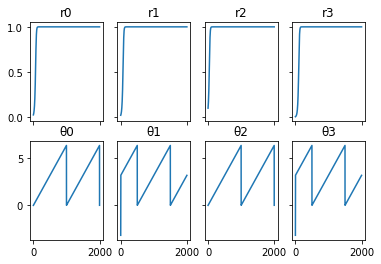

In [4]:
x = range(int_X.shape[0])

fig, axs = plt.subplots(2, 4, sharex=True, sharey='row')

axs[0, 0].plot(x, int_X[:,0,0])
axs[0, 0].set_title("r0")
axs[0, 1].plot(x, int_X[:,0,1])
axs[0, 1].set_title("r1")
axs[0, 2].plot(x, int_X[:,0,2])
axs[0, 2].set_title("r2")
axs[0, 3].plot(x, int_X[:,0,3])
axs[0, 3].set_title("r3")

axs[1, 0].plot(x, int_X[:,1,0])
axs[1, 0].set_title("θ0")
axs[1, 1].plot(x, int_X[:,1,1])
axs[1, 1].set_title("θ1")
axs[1, 2].plot(x, int_X[:,1,2])
axs[1, 2].set_title("θ2")
axs[1, 3].plot(x, int_X[:,1,3])
axs[1, 3].set_title("θ3");

We can check that indeed the oscillator phases respect the gait timing. This looks ok.

Now, we implement the update function of the HopfNetwork class. We simply map the cpg oscillator states to cartesion coordinates for the feet x and z positions (y are constant).

PACE

Positions for first step : 
x: [[-0.00221799  0.00321634 -0.00099598  0.00122591]] 
z: [[-0.24968584 -0.25006283 -0.24968584 -0.25006283]]

Positions after next step : 
x: [-0.00232841  0.00337592 -0.00104568  0.00128708] 
z: [-0.2493717  -0.25012566 -0.2493717  -0.25012566]

Positions after many steps : 
x: [-0.03999684  0.03999684 -0.03999684  0.03999684] 
z: [-0.2493717  -0.25012566 -0.2493717  -0.25012566]


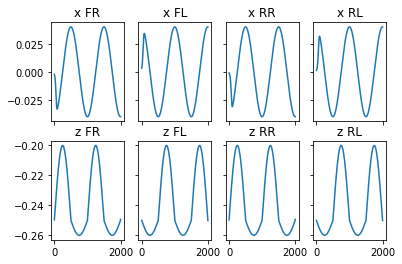

In [5]:
int_cpg = HopfNetwork(gait="PACE")
x, z = int_cpg.update()
x_arr = np.array([x])
z_arr = np.array([z])
print(f"\nPositions for first step : \nx: {x_arr} \nz: {z_arr}")
x, z = int_cpg.update()
x_arr = np.append(x_arr, [x], axis=0)
z_arr = np.append(z_arr, [z], axis=0)
print(f"\nPositions after next step : \nx: {x} \nz: {z}")

for i in range(2000):
    x, z = int_cpg.update()
    x_arr = np.append(x_arr, [x], axis=0)
    z_arr = np.append(z_arr, [z], axis=0)
print(f"\nPositions after many steps : \nx: {x} \nz: {z}")

x = range(x_arr.shape[0])

fig, axs = plt.subplots(2, 4, sharex=True, sharey='row')

# Order is FR, FL, RR, RL
axs[0, 0].plot(x, x_arr[:,0])
axs[0, 0].set_title("x FR")
axs[0, 1].plot(x, x_arr[:,1])
axs[0, 1].set_title("x FL")
axs[0, 2].plot(x, x_arr[:,2])
axs[0, 2].set_title("x RR")
axs[0, 3].plot(x, x_arr[:,3])
axs[0, 3].set_title("x RL")

axs[1, 0].plot(x, z_arr[:,0])
axs[1, 0].set_title("z FR")
axs[1, 1].plot(x, z_arr[:,1])
axs[1, 1].set_title("z FL")
axs[1, 2].plot(x, z_arr[:,2])
axs[1, 2].set_title("z RR")
axs[1, 3].plot(x, z_arr[:,3])
axs[1, 3].set_title("z RL");

We can see that the feet positions, in the referential of the robot, are indeed moving as expected, with regular oscillations, with the robot height as 0.25, we can see that the feet touch the ground and "penetrate" about (from -0.25 to -0.26) 0.01, but this is not actual ground penetration, it will only force to push strongly against the ground.

# TO BE CONTINUED

In [ ]:
# initialize Hopf Network, supply gait
cpg = HopfNetwork(
                mu=1**2,                # converge to sqrt(mu)
                omega_swing=1*2*np.pi,  # MUST EDIT
                omega_stance=1*2*np.pi, # MUST EDIT
                gait="TROT",            # change depending on desired gait
                coupling_strength=1,    # coefficient to multiply coupling matrix
                couple=True,            # should couple
                time_step=TIME_STEP,    # time step 
                ground_clearance=0.05,  # foot swing height 
                ground_penetration=0.01,# foot stance penetration into ground 
                robot_height=0.25,      # in nominal case (standing) 
                des_step_len=0.04      # desired step length 
                )

simulation_duration = 10 # (in seconds)
TEST_STEPS = int(simulation_duration / (TIME_STEP))
t = np.arange(TEST_STEPS)*TIME_STEP

# [TODO] initialize data structures to save CPG and robot states



In [ ]:
############## Sample Gains
# joint PD gains
kp=np.array([150,70,70])
kd=np.array([2,0.5,0.5])
# Cartesian PD gains
kpCartesian = np.diag([2500]*3)
kdCartesian = np.diag([40]*3)


for j in range(TEST_STEPS):
    # initialize torque array to send to motors
    action = np.zeros(12) 
    # get desired foot positions from CPG 
    xs,zs = cpg.update()
    # [TODO] get current motor angles and velocities for joint PD, see GetMotorAngles(), GetMotorVelocities() in quadruped.py
    # q = 
    # dq = 
    
    # loop through desired foot positions and calculate torques
    for i in range(4):
        # initialize torques for legi
        tau = np.zeros(3)
        # get desired foot i pos (xi, yi, zi) in leg frame
        leg_xyz = np.array([xs[i],sideSign[i] * foot_y,zs[i]])
        # call inverse kinematics to get corresponding joint angles (see ComputeInverseKinematics() in quadruped.py)
        leg_q = np.zeros(3) # [TODO] 
        # Add joint PD contribution to tau for leg i (Equation 4)
        tau += np.zeros(3) # [TODO] 
        
        # add Cartesian PD contribution
        if ADD_CARTESIAN_PD:
            # Get current Jacobian and foot position in leg frame (see ComputeJacobianAndPosition() in quadruped.py)
            # [TODO] 
            # Get current foot velocity in leg frame (Equation 2)
            # [TODO] 
            # Calculate torque contribution from Cartesian PD (Equation 5) [Make sure you are using matrix multiplications]
            tau += np.zeros(3) # [TODO]
        
        # Set tau for legi in action vector
        action[3*i:3*i+3] = tau
    
    # send torques to robot and simulate TIME_STEP seconds 
    env.step(action) 
    
    # [TODO] save any CPG or robot states
    

In [ ]:
##################################################### 
# PLOTS
#####################################################
# example
# fig = plt.figure()
# plt.plot(t,joint_pos[1,:], label='FR thigh')
# plt.legend()
# plt.show()

In [ ]:
# time.sleep(2)
pybullet.disconnect()